# Spectrum analysis - SNR, SINAD, THD, ENOB, WTF...



The signal analysis method(s) described here are very popular for characterising the perfomance of ADC-s.
However, these should be applicable for finding the right gain values for transmitting/receiving RF signals. The benefit of using a single (or a pair of) unmodulated sine wave is to easily identify and distinguish harmonics (due to distortion) from noise. Using wide-band sources for estimating the transfer function of the channel cannot do this, but should be the next logical step after finding the optimal TX/RX gain values. 

Good detailed description: http://www.analog.com/media/en/training-seminars/tutorials/MT-003.pdf

In [17]:
%matplotlib inline
from itertools import combinations
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import get_window

FS = 20e6          # sampling freq
N = int(1e5)       # number of samples
FREQ = 3 * FS / 20 # frequency of the signal (avoid harmonics near DC)
N_FFT = 8192
N_HARMONICS = 3    # number of harmonics to consider in distortion
A_SIGNAL = .7      # amplitude values for the synthesized signal
A_NOISE = .0001
A_DC = .05
BETA = .7          # magical third order distortion factor
CHANNEL_WIDTH = 6  # number of adjacent freq bins to capture a component
EPSILON = np.finfo(float).eps

## Signal generation and specturm estimation

We are generating a sampled complex sine wave with added white noise, DC offset and distortion. Alternatively, you can load a recorded RF signal (with the same FS and FREQ parameters).
We intentionally avoided the built-in spectrum estimation methods (e.g. scipy.signal.periodogram) to show the details of the process. __NOTE__: the result vector is __power spectrum__, thus each element represents the total / integrated power within the bin.

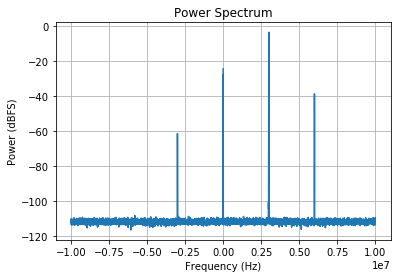

In [24]:
# Option 1: generate signal
t = np.linspace(0, N / FS, N)
signal = A_SIGNAL * np.exp(2j * np.pi * FREQ * t)
noise = A_NOISE * (np.random.randn((N)) + 1j * np.random.randn((N)))
dc = A_DC * np.ones((N))
samples = signal + noise + dc

# add third order distortion - harmonics
samples += samples * (samples * samples.conj()) * BETA 


# Option 2: load real RF signal (recorded on the SC2 Colosseum)
#samples = np.fromfile('colosseum_tx32_rx16.dat', dtype=np.complex64)

# power spectrum estimation 
f = np.fft.fftfreq(N_FFT, 1/FS)
win = get_window('blackmanharris', N_FFT)
norm = N_FFT * np.sqrt(np.sum(win ** 2)  / N_FFT)
offsets = list(range(0, len(samples) - N_FFT, int(N_FFT/ 2))) # half overlap
specgram = np.empty((len(offsets), N_FFT), dtype=np.float)
for i, offset in enumerate(offsets):
    x = np.fft.fft(win * samples[offset:offset+N_FFT], n=N_FFT) / norm
    specgram[i, :] = np.abs(x) ** 2
spectrum = np.mean(specgram, axis=0)
spectrum_db = 10*np.log10(spectrum + EPSILON)

plt.plot(f, spectrum_db)
plt.grid()
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power (dBFS)')
plt.title('Power Spectrum')
plt.show()

## Signal components

We are separating the spectrum to __signal__, __dc__, __harmonics__ and __noise__ components. First, we find the center FFT bins (except for the noise), then we add a few adjacent bins to be sure, everything is captured.
Note the way, harmonics are identified (+/- frequencies). *TODO: This might need some better understanding / explanation*

We also do some safety checks (of the bin allocation algorithm) and verify, if the most significant frequency component (ignoring DC) is where we expect the carrier.

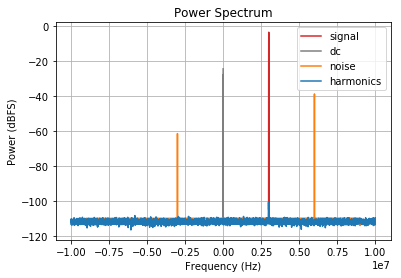

In [25]:
# assign fft bins to categories: signal, dc, harmonics, noise
def freq_to_bin(freq):
    return int(freq / FS * N_FFT) % N_FFT

def bin_distance(bin1, bin2):
    d1= (bin1 - bin2) % N_FFT
    d2 = (bin2 - bin1) % N_FFT
    return min(d1, d2)

signal_center = freq_to_bin(FREQ)
dc_center = 0
harmonics = [h for h in range(-N_HARMONICS, N_HARMONICS + 2) if h not in (0, 1)]
harmonic_centers = [freq_to_bin(FREQ * i) for i in harmonics]

signal_bins = []
noise_bins = []
dc_bins = []
harmonic_bins = []
for b in range(N_FFT):
    if  bin_distance(b, signal_center) < CHANNEL_WIDTH:
        signal_bins.append(b)
        continue
    if bin_distance(b, dc_center) < CHANNEL_WIDTH:
        dc_bins.append(b)
        continue
    for harmonic_center in harmonic_centers:
        if bin_distance(b, harmonic_center) < CHANNEL_WIDTH:
            harmonic_bins.append(b)
            break
    else:
        noise_bins.append(b)


# safety checks
assert len(signal_bins) + len(noise_bins) + len(dc_bins) + len(harmonic_bins) == N_FFT
for s1, s2 in combinations([set(signal_bins), 
                                      set(noise_bins), 
                                      set(dc_bins), 
                                      set(harmonic_bins)], 2):
    assert len(s1 & s2) == 0

spectrum_nodc = spectrum.copy()
spectrum_nodc[dc_bins] = 0.0
if bin_distance(signal_center, np.argmax(spectrum_nodc)) > 1:
    print("WARNING: cannot find carrier")


plt.plot(f[signal_bins], spectrum_db[signal_bins], 'C3')
plt.plot(f[dc_bins], spectrum_db[dc_bins], 'C7')
plt.plot(f[harmonic_bins], spectrum_db[harmonic_bins], 'C1')
plt.plot(f[noise_bins], spectrum_db[noise_bins], 'C0')
plt.legend(['signal', 'dc', 'noise', 'harmonics']);
plt.grid()
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power (dBFS)')
plt.title('Power Spectrum')
plt.show()

## Measurements

With the clearly separated frequency components, we can calculate the various performance values. First, we compute the total power of each component, by summing the relevant frequency bins. Assuming white noise, we calculate the average *per bin* value of the noise. This average value is used to subtract the noise level from other categories and to compute the total noise power.

The definition of SNR, SINAD, THD and ENOB should be clear from the code.

In [5]:
# measurements
avg_n = np.sum(spectrum[noise_bins]) / len(noise_bins)

p_signal = np.sum(spectrum[signal_bins]) - avg_n * len(signal_bins)
p_dc = np.sum(spectrum[dc_bins]) - (avg_n * len(dc_bins))
p_harmonics = np.sum(spectrum[harmonic_bins]) - avg_n * len(harmonic_bins)
p_noise = avg_n *  N_FFT 

# safeguards:
p_signal = max(p_signal, EPSILON)
p_dc = max(p_dc, EPSILON)
p_harmonics = max(p_harmonics, EPSILON)
p_noise = max(p_noise, EPSILON)

snr = 10 * np.log10(p_signal / p_noise)
sinad = 10 * np.log10(p_signal / (p_noise + p_harmonics))
thd = 10 * np.log10(p_harmonics / p_signal)
thd_pct = 100.0 * p_harmonics / p_signal 
enob = (sinad - 1.76) / 6.02

print("Signal power: %.1f dB" % (10 * np.log10(p_signal)))
print("DC power: %.1f dB" % (10 * np.log10(p_dc)))
print("Noise power: %.1f dB" % (10 * np.log10(p_noise)))
print("SNR: %.1f dB, SINAD: %.1f dB, THD: %.1f dB (%.1f %%), ENOB: %d bits" % (snr, sinad, thd, thd_pct, int(enob)))

#TODO: spurs, carrier finding


Signal power: -0.4 dB
DC power: -21.4 dB
Noise power: -32.2 dB
SNR: 31.8 dB, SINAD: 30.0 dB, THD: -34.7 dB (0.0 %), ENOB: 4 bits


## TODO:

Instead of using the harmonics series, we might employ a generic peak finding method. The benefit of this approach is that it can find spurious emissions, also. If you are interested, the python PeakUtils